In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Latent Dirichlet Allocation (LDA) Model using scikit-learn
catalog_data = pd.read_csv('./cleaned-catalog.csv')
job_data = pd.read_csv('./cleaned-job-descriptions.csv')

catalog_stopwords = nltk.corpus.stopwords.words('english')
job_stopwords = nltk.corpus.stopwords.words('english')

# add custom stopwords for course descriptions
catalog_stopwords.extend(['see', 'prerequisite', 'hour', 'hours', 'freshman', 'sophomore', 'junior', 'senior', 'standing', 'credit', 'consent', 'equivalent', 'undergraduate', 'graduate', \
                           'may', 'taken', 'course', 'courses', 'students', 'student', 'topics', 'include', 'includes', 'including', 'introduction', 'repeated', 'intended', \
                            'su', 'eps', 'instructor', 'section', 'one', 'vary', 'maximum', 'degree', 'program', 'department', 'register', 'per', 'term', 'terms', 'registration', \
                            'completed', 'concurrently', 'enrolled', 'enrollment', 'approved', 'letter', 'grading', 'major', 'majors', 'fees', 'apply', 'illinois', 'andor', 'passing' \
                            'summer', 'carle', 'concurrent', 'class', 'week', 'semester', 'semesters', 'required', 'using', 'examine', 'examines', 'restricted', 'phase', 'separate', \
                            'use', 'departmental', 'approval', 'offered', 'years', 'college', 'must', 'given', 'faculty', 'new', 'prerequisites', 'areas', 'offerings', 'schedule', \
                            'part' 'level', 'continuation', 'toward', 'whose', 'additional', 'gpa'])
# should add each subject as a stopword since they are mentioned in the descriptions
for subject in catalog_data['Subject'].unique():
    catalog_stopwords.append(subject.lower())



# Create a vectorizer for LDA
catalog_vectorizer = TfidfVectorizer(stop_words=catalog_stopwords, max_df=0.95, min_df=2)
course_count_data = catalog_vectorizer.fit_transform(catalog_data['Description'])

job_vectorizer = TfidfVectorizer(stop_words=job_stopwords, max_df=0.95, min_df=2)
job_count_data = job_vectorizer.fit_transform(job_data['job_description'])


n_topics = 10
course_lda = LatentDirichletAllocation(n_components=n_topics)
course_lda.fit(course_count_data)

job_lda = LatentDirichletAllocation(n_components=n_topics)
job_lda.fit(job_count_data)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print("\t" + " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Course Topics:\n")
display_topics(course_lda, catalog_vectorizer.get_feature_names_out(), no_top_words)
print("\nJob Topics:\n")
display_topics(job_lda, job_vectorizer.get_feature_names_out(), no_top_words)

Course Topics:

Topic 0:
	health social management professional issues development medicine skills systems human
Topic 1:
	augment existing information cultural subject developing engineering american history chemistry
Topic 2:
	data design analysis systems methods techniques theory applications statistical programming
Topic 3:
	research study individual special topic professional independent selected thesis work
Topic 4:
	music audition level applied instruction jazz completion prior performance passing

Job Topics:

Topic 0:
	app testing grocery clerk inventory tele telemetry ignite fanatics retail
Topic 1:
	grocery tele telemetry ignite fanatics hey addressable reps nbc dev
Topic 2:
	msnbc cnc telemetry clarapath tele nbcuniversal tolerances axis spindle gauges
Topic 3:
	experience work sales team customer business marketing skills ability management
Topic 4:
	directv vera fanatics veras addressable ignite configures harness equityboth sincerelyheld


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (10).

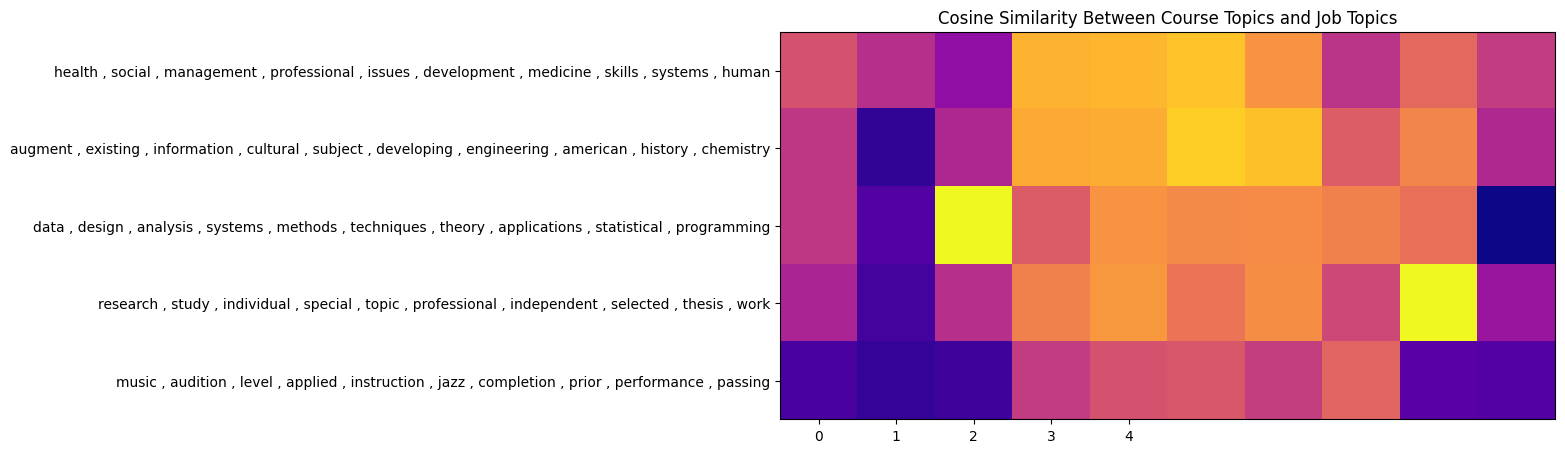

In [51]:
import spacy

# Load the pre-trained spaCy model with word vectors
nlp = spacy.load("en_core_web_md")

def get_topic_keywords(lda_model, feature_names, n_top_words=10):
    """
    Extracts the top N words for each topic from an LDA model.
    Args:
    lda_model (LatentDirichletAllocation): The trained LDA model.
    feature_names (list): List of feature names corresponding to the vocabulary.
    n_top_words (int): Number of top words to extract for each topic.
    Returns:
    list of list: A list of lists, where each sublist contains the top N words for a topic.
    """
    top_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(top_features)
    return top_words

def get_average_vector(words):
    """
    Computes the average vector for a list of words using spaCy's word vectors.
    Args:
    words (list): List of words to compute the average vector for.
    Returns:
    np.ndarray: The average vector of the input words.
    """
    vectors = [nlp(word).vector for word in words if nlp(word).has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(nlp.vocab.vectors_length)

def topic_labels(top_words_list):
    labels = [' , '.join(words) for words in top_words_list]
    return labels

predefined_skills = ['problem solving', 'teamwork', 'data analysis', 'critical thinking', 'project management', 'communication', 'information literacy', 'programming', 'research', 'leadership']
skill_vectors = [get_average_vector([skill]) for skill in predefined_skills]




feature_names_courses = catalog_vectorizer.get_feature_names_out()
top_words_courses = get_topic_keywords(course_lda, feature_names_courses)
average_vector_courses = [get_average_vector(words) for words in top_words_courses]

# Then use cosine_similarity to compare average vectors between courses and jobs
similarities = cosine_similarity(average_vector_courses, skill_vectors)


course_labels = topic_labels(top_words_courses)

# heatmap with labels
plt.figure(figsize=(10, 10))
plt.title('Cosine Similarity Between Course Topics and Job Topics')
plt.imshow(similarities, cmap='plasma', interpolation='nearest')
plt.yticks(range(n_topics), course_labels)
plt.xticks(range(n_topics), predefined_skills, rotation=60)
plt.colorbar()
plt.show()

# print the most similar course topics for each skill
for i, skill in enumerate(predefined_skills):
    most_similar_topic = np.argmax(similarities[:, i])
    print(f"Most similar course topic for skill '{skill}': {course_labels[most_similar_topic]}")

